# DivCon: Division & Consensus Analysis Experiment

エネルギー基本計画に対する市民意見から対立軸を発見する実験

## アルゴリズム
1. **Stage 1**: トピック検出（sensemakerの方式）
2. **Stage 2**: 文章のトピック分類
3. **Stage 3a**: 対立軸の発見
4. **Stage 3b**: 極端意見アンカーの生成（左右各10個）
5. **Stage 4**: 強度推定（1-5スコア）

**データ**: 1024件のエネルギー基本計画への市民意見

## セル1: 環境セットアップ

In [1]:
# 必要なライブラリのインストール
# !pip install openai python-dotenv pandas matplotlib seaborn pydantic

import os
import json
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel
from typing import List
import random

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

# .envファイルから環境変数を読み込み
load_dotenv()

# OpenAI クライアント初期化
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
MODEL = os.getenv('OPENAI_MODEL', 'gpt-5-mini')
REASONING_EFFORT = os.getenv('REASONING_EFFORT', 'medium')

print(f"✓ OpenAI client initialized")
print(f"✓ Model: {MODEL}")
print(f"✓ Reasoning Effort: {REASONING_EFFORT}")

✓ OpenAI client initialized
✓ Model: gpt-5-mini
✓ Reasoning Effort: medium


## セル2: データ読み込み

In [2]:
# データ読み込み
df = pd.read_csv('data/opinions.csv')

print(f"データ件数: {len(df)} 件")
print(f"\nカラム: {list(df.columns)}")
print(f"\n最初の3件:")
display(df.head(3))

# 意見をリストとして保持
opinions = df.to_dict('records')
print(f"\n✓ {len(opinions)} 件の意見を読み込みました")

データ件数: 1024 件

カラム: ['id', 'comment']

最初の3件:


,id,comment
0,1,当社は地球温暖化防止の方向性について賛同し、第7次エネルギー基本計画に賛同いたします。
1,2,「バランスのとれたＳ＋３Ｅの実現」を基本方針として検討、策定されている点について、賛同する。
2,3,今回示されたエネルギー基本計画案は、S＋3Eの原則のもと、わが国の国民生活、経済活動を支える...



✓ 1024 件の意見を読み込みました


## セル3: Stage 1 - トピック検出

全ての意見から主要なトピックを自動抽出します。

In [3]:
# Stage 1用のPydanticモデル定義
class Topic(BaseModel):
    id: str
    name: str
    description: str

class TopicDiscoveryResponse(BaseModel):
    topics: List[Topic]
    reasoning: str

# サンプリング（全件は高コストなので、まず100件程度でテストを推奨）
SAMPLE_SIZE = 1000000
sample_opinions= random.choices(opinions, k=SAMPLE_SIZE) if len(opinions) > SAMPLE_SIZE else opinions[:SAMPLE_SIZE]

# 意見テキストを結合
opinions_text = "\n\n".join([f"[{op['id']}] {op['comment']}" for op in sample_opinions])

# プロンプト
prompt_stage1 = f"""以下は、エネルギー基本計画に対する市民意見です。

これらの意見を分析し、主要なトピック（議論の主題）を抽出してください。

【意見一覧】
{opinions_text}

【指示】
1. この中で議論されている主要なトピックは何ですか？
2. 最適なトピック数を自動で判断してください（3-7個程度を推奨）
3. 各トピックに明確な名前と説明を付けてください
"""

print("Stage 1: トピック検出中...")

# Structured Outputsを使用
completion = client.beta.chat.completions.parse(
    model=MODEL,
    messages=[
        {"role": "system", "content": "あなたは市民意見を分析する専門家です。意見を読み、主要なトピックを抽出してください。"},
        {"role": "user", "content": prompt_stage1}
    ],
    reasoning_effort=REASONING_EFFORT,
    response_format=TopicDiscoveryResponse
)

result_stage1 = completion.choices[0].message.parsed
topics = [t.model_dump() for t in result_stage1.topics]

print(f"\n✓ {len(topics)} 個のトピックを検出しました\n")
print(f"理由: {result_stage1.reasoning}\n")

for topic in topics:
    print(f"[{topic['id']}] {topic['name']}")
    print(f"    {topic['description']}")
    print()

Stage 1: トピック検出中...

✓ 7 個のトピックを検出しました

理由: 寄せられた膨大な市民意見を網羅的に読取り、重複・分散する論点を整理しました。助言・評価・反対表明などの「計画への賛否」と、気候目標の科学的妥当性は市民の関心が特に高く（T1,T2）。電源別の意見は再生可能エネルギー、原子力、化石燃料／脱炭素火力に大別でき、各々が独立した大きな論点を形成していたため（T3,T4,T5）独立トピックとしました。加えて、費用負担や産業競争力、エネルギー安全保障に関する経済的視点が繰返し挙がっており（T6）、再エネ導入や鉱物資源開発が引き起こす自然・社会的影響と世代間公平性も多数の意見で重要視されていたため（T7）独立させました。以上7項目は、提出意見群の主要な対立軸と改善要求を網羅的かつ読みやすく表現する最適な粒度（3〜7個の推奨範囲）であると判断しました。

[T1] 計画への賛否・意思決定プロセス
    第7次エネルギー基本計画案そのものへの賛成・反対、廃案要求、パブリックコメントや審議会の構成・透明性・国会審議の要望など、政策策定過程の正当性・民主性に関する議論。

[T2] 気候目標の野心度と科学的根拠
    2030/2035/2040/2050などのGHG削減目標の妥当性・上方修正の要求、IPCC等の科学的整合性、オントラック評価への疑義、カーボンバジェットやNDCとの整合性に関する論点。

[T3] 再生可能エネルギーの拡大と系統整備
    太陽光・陸上/洋上風力・地熱・水力・小水力などの導入目標・内訳、系統（送配電）強化、蓄電・揚水・DER・デマンドレスポンスによる統合、出力抑制・環境影響・地域共生に関する議論。

[T4] 原子力の位置づけ（再稼働・新設・廃炉・廃棄物）
    原子力の『最大限活用』方針への賛否、再稼働・新増設・運転延長、次世代革新炉・SMR、核燃料サイクル・六ヶ所再処理、廃炉・高レベル廃棄物問題、福島教訓の扱いに関する争点。

[T5] 化石燃料・脱炭素火力と代替技術（CCS・水素・アンモニア等）
    石炭の段階的廃止/維持、LNGの役割、ゼロエミッション火力の実用性、CCS/CCUSやBECCS・DACCSの可否、水素・アンモニア・合成燃料の支援・コスト・供給チェーンに関する議論。

[T6] 経済性・

## セル4: Stage 2 - トピック分類

各意見をトピックに割り当てます。

In [4]:
# Stage 2用のPydanticモデル定義
class Classification(BaseModel):
    opinion_id: str
    topic_id: str

class ClassificationResponse(BaseModel):
    classifications: List[Classification]

# トピック定義を文字列化
topics_text = "\n".join([f"[{t['id']}] {t['name']}: {t['description']}" for t in topics])

# バッチ処理（10件ずつ分類）
BATCH_SIZE = 10
classified_opinions = []

for i in range(0, len(sample_opinions), BATCH_SIZE):
    batch = sample_opinions[i:i+BATCH_SIZE]
    batch_text = "\n".join([f"[{op['id']}] {op['comment']}" for op in batch])
    
    prompt_stage2 = f"""以下のトピック定義があります:

{topics_text}

次の意見を、最も適切なトピックに分類してください:

{batch_text}

【重要】opinion_idとtopic_idは必ず上記のリストに存在するIDを使用してください。
"""
    
    # Structured Outputsを使用
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content": "意見を適切なトピックに分類してください。指定されたIDのみを使用してください。"},
            {"role": "user", "content": prompt_stage2}
        ],
        reasoning_effort=REASONING_EFFORT,
        response_format=ClassificationResponse
    )
    
    result = completion.choices[0].message.parsed
    classified_opinions.extend([c.model_dump() for c in result.classifications])
    
    print(f"✓ {i+1}-{i+len(batch)} 件を分類")

# 分類結果を元のデータに追加
classification_map = {c['opinion_id']: c['topic_id'] for c in classified_opinions}
for op in sample_opinions:
    op['topic_id'] = classification_map.get(str(op['id']), None)

# トピックごとの件数（Noneを除外）
topic_counts = pd.Series([op['topic_id'] for op in sample_opinions if op['topic_id'] is not None]).value_counts()
print(f"\n✓ 分類完了\n")

# 有効なトピックIDのセット
valid_topic_ids = {t['id'] for t in topics}

for topic_id, count in topic_counts.items():
    # topic_idが有効か確認
    if topic_id in valid_topic_ids:
        topic_name = next(t['name'] for t in topics if t['id'] == topic_id)
        print(f"[{topic_id}] {topic_name}: {count} 件")
    else:
        print(f"[{topic_id}] (不明なトピック): {count} 件 ⚠️")

# 未分類の件数
unclassified = sum(1 for op in sample_opinions if op['topic_id'] is None)
if unclassified > 0:
    print(f"\n未分類: {unclassified} 件 ⚠️")

✓ 1-10 件を分類
✓ 11-20 件を分類
✓ 21-30 件を分類
✓ 31-40 件を分類
✓ 41-50 件を分類
✓ 51-60 件を分類
✓ 61-70 件を分類
✓ 71-80 件を分類
✓ 81-90 件を分類
✓ 91-100 件を分類
✓ 101-110 件を分類
✓ 111-120 件を分類
✓ 121-130 件を分類
✓ 131-140 件を分類
✓ 141-150 件を分類
✓ 151-160 件を分類
✓ 161-170 件を分類
✓ 171-180 件を分類
✓ 181-190 件を分類
✓ 191-200 件を分類
✓ 201-210 件を分類
✓ 211-220 件を分類
✓ 221-230 件を分類
✓ 231-240 件を分類
✓ 241-250 件を分類
✓ 251-260 件を分類
✓ 261-270 件を分類
✓ 271-280 件を分類
✓ 281-290 件を分類
✓ 291-300 件を分類
✓ 301-310 件を分類
✓ 311-320 件を分類
✓ 321-330 件を分類
✓ 331-340 件を分類
✓ 341-350 件を分類
✓ 351-360 件を分類
✓ 361-370 件を分類
✓ 371-380 件を分類
✓ 381-390 件を分類
✓ 391-400 件を分類
✓ 401-410 件を分類
✓ 411-420 件を分類
✓ 421-430 件を分類
✓ 431-440 件を分類
✓ 441-450 件を分類
✓ 451-460 件を分類
✓ 461-470 件を分類
✓ 471-480 件を分類
✓ 481-490 件を分類
✓ 491-500 件を分類
✓ 501-510 件を分類
✓ 511-520 件を分類
✓ 521-530 件を分類
✓ 531-540 件を分類
✓ 541-550 件を分類
✓ 551-560 件を分類
✓ 561-570 件を分類
✓ 571-580 件を分類
✓ 581-590 件を分類
✓ 591-600 件を分類
✓ 601-610 件を分類
✓ 611-620 件を分類
✓ 621-630 件を分類
✓ 631-640 件を分類
✓ 641-650 件を分類
✓ 651-660 件を分類
✓ 661-670 件を分類
✓ 671-680 件を分類


## セル5: Stage 3a - 対立軸の発見

各トピック内で対立している軸を発見します。

In [5]:
# Stage 3a用のPydanticモデル定義
class Axis(BaseModel):
    id: str
    name: str
    left_pole: str
    right_pole: str
    strength: int  # 1-5の5段階評価
    reasoning: str

class AxisDiscoveryResponse(BaseModel):
    axes: List[Axis]

# 最初のトピックで実験（後で全トピックに拡張可能）
target_topic = topics[0]
topic_opinions = [op for op in sample_opinions if op['topic_id'] == target_topic['id']]

print(f"トピック [{target_topic['id']}] {target_topic['name']}")
print(f"意見数: {len(topic_opinions)} 件\n")

# 意見テキストを結合
topic_opinions_text = "\n\n".join([f"[{op['id']}] {op['comment']}" for op in topic_opinions])

prompt_stage3a = f"""以下は、「{target_topic['name']}」というトピックに関する市民意見です。

{topic_opinions_text}

【タスク】
この意見群の中で、人々が**対立している軸**を発見してください。

対立軸とは:
- 意見が二極化している次元
- 「AかBか」という選択を迫られる論点
- 例: "環境保護 vs 経済成長", "短期的利益 vs 長期的持続性"

【指示】
1. 主要な対立軸を2-4個抽出してください
2. 各軸に明確な名前を付けてください（"A vs B"の形式）
3. 対立の強度を5段階で評価してください：
   - 5: 非常に強い対立（意見が完全に二極化）
   - 4: 強い対立
   - 3: 中程度の対立
   - 2: やや対立
   - 1: 弱い対立
"""

print("Stage 3a: 対立軸発見中...")

# Structured Outputsを使用
completion = client.beta.chat.completions.parse(
    model=MODEL,
    messages=[
        {"role": "system", "content": "あなたは対立構造を分析する専門家です。"},
        {"role": "user", "content": prompt_stage3a}
    ],
    reasoning_effort=REASONING_EFFORT,
    response_format=AxisDiscoveryResponse
)

result_stage3a = completion.choices[0].message.parsed
axes = [a.model_dump() for a in result_stage3a.axes]

print(f"\n✓ {len(axes)} 個の対立軸を発見しました\n")

for axis in axes:
    strength_label = ["", "弱い", "やや", "中程度", "強い", "非常に強い"][axis['strength']]
    print(f"[{axis['id']}] {axis['name']}")
    print(f"    左極: {axis['left_pole']}")
    print(f"    右極: {axis['right_pole']}")
    print(f"    強度: {axis['strength']}/5 ({strength_label}対立)")
    print(f"    理由: {axis['reasoning']}")
    print()

トピック [T1] 計画への賛否・意思決定プロセス
意見数: 88 件

Stage 3a: 対立軸発見中...

✓ 4 個の対立軸を発見しました

[axis_1] 計画に賛成 vs 計画に反対
    左極: 賛成（第7次計画案を支持・推進）
    右極: 反対（廃案・撤回を要求）
    強度: 5/5 (非常に強い対立)
    理由: 意見群は計画案そのものに対して明確に二極化している。賛成側は[1][2][3][4][5][6][7]等で計画の方向性やS+3Eのバランスを評価・支持している。一方で反対側は[9][10][11][12][13][14][15]などで廃案・撤回や強い反対意見を述べており、対立は非常に強い。

[axis_2] 脱炭素優先 vs 安定供給・経済効率優先
    左極: 脱炭素（再エネ加速・原発縮小を優先）
    右極: 安定供給・経済効率（脱炭素と並ぶ供給安定・経済性重視）
    強度: 4/5 (強い対立)
    理由: 多くの意見が政策優先順位で対立している。脱炭素・再エネ重視を求める意見（例：[14][55][56][240]等）と、地政学的リスクや産業ニーズを踏まえ安定供給・経済性を重視する意見（例：[3][5][6][7][1020]等）が目立つ。双方とも強い主張があり妥協はあるが対立は強い。

[axis_3] 原子力推進 vs 反原発（縮小・廃止）
    左極: 原子力推進（再稼働・新設、法改正で地域同意不要等）
    右極: 反原発（再稼働・新増設反対、安全・持続性重視）
    強度: 4/5 (強い対立)
    理由: 原子力に関して明確な分断がある。推進側は[821][822]等で法改正や同意不要の主張、原子力を安価・安定・脱炭素の手段とする意見がある。一方、反対側は[808][881][887]等で強く反対し、廃止や住民投票を求める声がある。議論は激しく、社会的敏感性も高い。

[axis_4] 省庁・専門家主導の意思決定 vs 民主的・透明な国民参加重視
    左極: 専門家・省庁・産業界主導（審議会・技術的検証重視）
    右極: 民主的・透明性・市民参加重視（国民的議論／国会審議／市民会議等）
    強度: 5/5 (非常に強い対立)
    理由: 多数の意見が政策決定プロ

## セル6: Stage 3b - アンカー生成（極端意見）

各対立軸について、既存の意見を参考に極端な文章例を生成します。
左右それぞれ10個、合計20個のアンカーを作成。

In [6]:
# Stage 3b用のPydanticモデル定義
class AnchorGenerationResponse(BaseModel):
    left_anchors: List[str]
    right_anchors: List[str]

# 最初の軸で実験
target_axis = axes[0]

print(f"対立軸 [{target_axis['id']}] {target_axis['name']}\n")

prompt_stage3b = f"""以下の市民意見を参考にして、対立軸「{target_axis['name']}」について、
極端に強い主張の文章例を生成してください。

【既存の意見（参考）】
{topic_opinions_text}

【タスク】
- **左極**（{target_axis['left_pole']}）の極端な主張を10パターン生成
- **右極**（{target_axis['right_pole']}）の極端な主張を10パターン生成

【極端な文章の例】
例えば、対立軸が「環境保護 vs 経済成長」の場合：

左極（環境保護）の例:
- 「経済成長を完全に停止してでも、環境保護を最優先すべきである」
- 「全ての企業活動を即座に規制し、自然環境を元の状態に戻すべきだ」
- 「人間の経済活動は地球環境に対する犯罪であり、全面的に見直すべきである」

右極（経済成長）の例:
- 「環境規制を全て撤廃し、経済成長を最大化すべきである」
- 「環境保護は経済発展の後で考えればよく、今は成長が最優先だ」
- 「環境コストを無視してでも、産業競争力を強化すべきである」

【重要なポイント】
1. 既存の意見の文脈を保ちつつ、より極端な表現にすること
2. 「完全に」「全て」「絶対に」「即座に」などの強い表現を使用
3. 妥協や条件を一切含まない断定的な主張にすること
4. 各パターンは異なる角度から極端さを表現すること
5. 同じような主張の繰り返しは避けること
"""

print("Stage 3b: アンカー生成中...")

# Structured Outputsを使用
completion = client.beta.chat.completions.parse(
    model=MODEL,
    messages=[
        {"role": "system", "content": "多様で極端な主張を生成してください。妥協のない、断定的な表現を使用してください。"},
        {"role": "user", "content": prompt_stage3b}
    ],
    reasoning_effort="high",  # アンカー生成は高精度で
    response_format=AnchorGenerationResponse
)

result_stage3b = completion.choices[0].message.parsed
anchors = {
    'left_anchors': result_stage3b.left_anchors,
    'right_anchors': result_stage3b.right_anchors
}

print(f"\n✓ アンカー生成完了\n")
print(f"左極アンカー（{target_axis['left_pole']}）: {len(anchors['left_anchors'])} 個")
for i, anchor in enumerate(anchors['left_anchors'], 1):
    print(f"  {i}. {anchor}")

print(f"\n右極アンカー（{target_axis['right_pole']}）: {len(anchors['right_anchors'])} 個")
for i, anchor in enumerate(anchors['right_anchors'], 1):
    print(f"  {i}. {anchor}")

対立軸 [axis_1] 計画に賛成 vs 計画に反対

Stage 3b: アンカー生成中...

✓ アンカー生成完了

左極アンカー（賛成（第7次計画案を支持・推進））: 10 個
  1. 第7次エネルギー基本計画案は国家の生存戦略であり、即刻かつ完全に閣議決定どおり全面実行し、いかなる反対や追加検討も一切認めてはならない。
  2. S＋3Eの均衡を追求する本計画は絶対に守るべき国策であり、原子力の再稼働・新設と再エネ拡大、化石燃料の合理的利用を同時並行で即座に推進すべきだ。
  3. 産業と国民生活を守るため、この計画を直ちに法律化し全企業・自治体に強制適用して、全ての関係者に従順な実行を義務付けるべきである。
  4. エネルギー安全保障は最優先であり、輸入依存を断つために計画に基づく全ての供給強化策を即刻実行し遅延を一切許してはならない。
  5. 脱炭素の理想と経済性の現実を両立させる本案は唯一の現実解であり、計画の変更や目標引き上げを要求する反対派の主張は受け入れられない。
  6. 製造業向けの安定電源確保は最優先事項だ。蒸気や高出力を必要とする産業には計画に基づく優先供給を完全に保障し、妨害する自治体には財政措置で対応すべきだ。
  7. 国益保護のために原子力の法的制約を即時に緩和し、地元同意要件を廃止して再稼働・増設を国家政策として最優先で実施せよ。
  8. この計画を支持する者は現実主義者であり、計画推進を妨げる市民運動やNGOの活動は法の枠内で厳格に制限すべきである。
  9. 2040年ロードマップは完成している。これを最短で実行に移すため、追加検証やパブコメの延長という遅延策は一切許容されない。
  10. 国家緊急の観点から本計画を国家緊急計画に格上げし、行政・企業・自治体は即時に連携して完全実施することを義務付けるべきだ。

右極アンカー（反対（廃案・撤回を要求））: 10 個
  1. 第7次エネルギー基本計画案は即刻完全に廃案にすべきであり、閣議決定の撤回と策定責任者の辞任を求める。
  2. 原発依存を復活させる本案は未来世代への犯罪だ。直ちに原子力の再稼働・新設を全面禁止し、計画を白紙撤回せよ。
  3. 化石燃料の延命を容認するこの案は気候破滅の設計図だ。即刻撤回し、2030年までに再エネ100%へ完全転換する新方

## セル7: Stage 4 - 強度推定

生成されたアンカーを基準に、実際の意見を1-5でスコアリング。

In [7]:
# Stage 4用のPydanticモデル定義
class Score(BaseModel):
    opinion_id: str
    score: int
    reasoning: str

class ScoringResponse(BaseModel):
    scores: List[Score]

# サンプル意見をスコアリング（最初の10件）
test_opinions = topic_opinions[:10]

# アンカーを文字列化
left_anchors_text = "\n".join([f"L{i+1}. {a}" for i, a in enumerate(anchors['left_anchors'])])
right_anchors_text = "\n".join([f"R{i+1}. {a}" for i, a in enumerate(anchors['right_anchors'])])

opinions_to_score = "\n\n".join([f"[{op['id']}] {op['comment']}" for op in test_opinions])

prompt_stage4 = f"""以下の基準アンカーに基づいて、意見をスコアリングしてください。

【対立軸】{target_axis['name']}

【左極アンカー】（スコア1に相当）
{left_anchors_text}

【右極アンカー】（スコア5に相当）
{right_anchors_text}

【スコアリング対象の意見】
{opinions_to_score}

【タスク】
各意見を1-5でスコアリングしてください:
- **1**: 左極アンカーに非常に近い
- **2**: 左極寄り
- **3**: バランス型・ブリッジ（両極の架け橋）
- **4**: 右極寄り
- **5**: 右極アンカーに非常に近い
"""

print("Stage 4: 強度推定中...")

# Structured Outputsを使用
completion = client.beta.chat.completions.parse(
    model=MODEL,
    messages=[
        {"role": "system", "content": "アンカーを基準に意見をスコアリングしてください。"},
        {"role": "user", "content": prompt_stage4}
    ],
    reasoning_effort=REASONING_EFFORT,
    response_format=ScoringResponse
)

result_stage4 = completion.choices[0].message.parsed
scores = [s.model_dump() for s in result_stage4.scores]

print(f"\n✓ スコアリング完了\n")

for score_data in scores:
    opinion = next(op for op in test_opinions if str(op['id']) == score_data['opinion_id'])
    print(f"[{opinion['id']}] スコア: {score_data['score']}")
    print(f"    意見: {opinion['comment'][:100]}...")
    print(f"    理由: {score_data['reasoning']}")
    print()

Stage 4: 強度推定中...

✓ スコアリング完了

[1] スコア: 2
    意見: 当社は地球温暖化防止の方向性について賛同し、第7次エネルギー基本計画に賛同いたします。...
    理由: 明確に『賛同します』とあり、S+3E等の方針支持を表明。強い実行要求や過激な国家介入は示しておらず、左極の絶対実行・強制化（L1,L3等）ほどではないため、左寄りだが穏健な評価として2。

[2] スコア: 2
    意見: 「バランスのとれたＳ＋３Ｅの実現」を基本方針として検討、策定されている点について、賛同する。...
    理由: 「バランスのとれたＳ＋３Ｅの実現」に賛同と明示。計画推進を支持する点で左寄り（L2等）だが、強硬な実行命令や反対排除を主張しておらず穏健な支持のため2。

[3] スコア: 2
    意見: 今回示されたエネルギー基本計画案は、S＋3Eの原則のもと、わが国の国民生活、経済活動を支えるエネルギー政策で、資源に乏しい島国であるわが国の地政学的なリスクも現実的に捉えており、脱炭素と経済性・安定供...
    理由: 脱炭素と経済性・安定供給のバランスを評価し、製造業の電源確保を擁護している。産業優先の立場で計画支持を表明しておりL2・L6に近いが極端な強制主張はないため2。

[4] スコア: 2
    意見: 第７次エネルギー基本計画（案）の方向性に賛同します...
    理由: 単純に『方向性に賛同します』とあり計画支持を示す。過激な実行や法的強制を求めていないため左寄り穏健の2。

[5] スコア: 2
    意見: 国の示す「我が国が将来にわたって豊かな国として存続し、全ての国民が希望をもって暮らせる社会を実現するためには、エネルギー安定供給、経済成長、脱炭素を同時に実現していく必要がある」という認識ならびに目指...
    理由: エネルギー安定供給・経済成長・脱炭素の同時実現という国の認識に賛同。方針支持で左寄りだが強硬性はなく2。

[6] スコア: 2
    意見: 第7次エネルギー基本計画（案）では、ウクライナ侵攻や中東情勢の緊迫化等に端を発したエネルギー安全保障の要請の高まり、DX,GX等の進展に伴う電力需要増加の見通し等エネルギーを取り巻く情勢変化を正面から...
    理由: 安全保障や経

## セル8: 結果の可視化

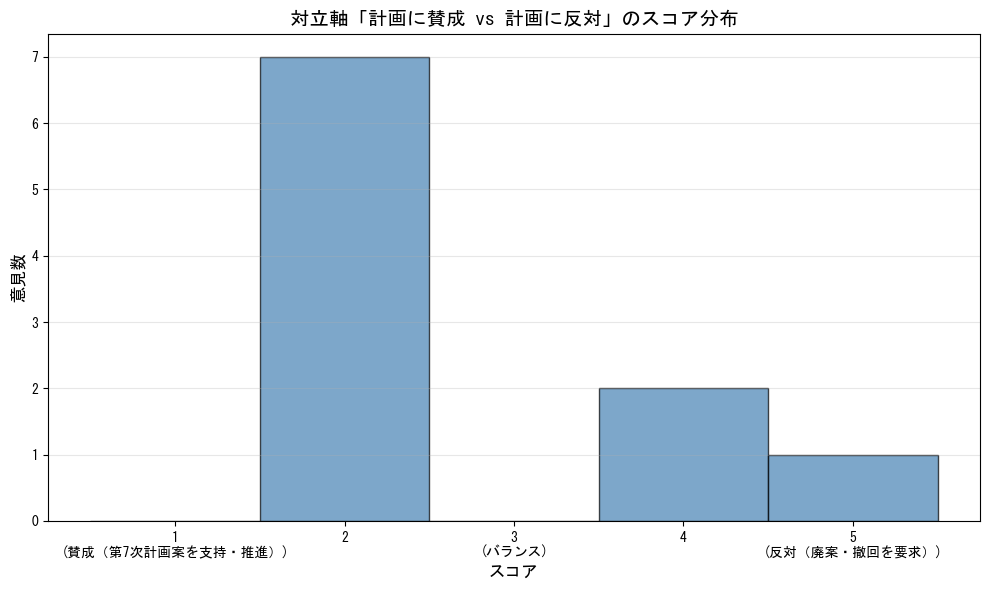


統計情報:
  平均: 2.70
  中央値: 2.0
  標準偏差: 1.10
  左極(1-2): 7 件
  バランス(3): 0 件
  右極(4-5): 3 件


In [8]:
# スコア分布のヒストグラム
score_values = [s['score'] for s in scores]

plt.figure(figsize=(10, 6))
plt.hist(score_values, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
         edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('スコア', fontsize=12)
plt.ylabel('意見数', fontsize=12)
plt.title(f'対立軸「{target_axis["name"]}」のスコア分布', fontsize=14, fontweight='bold')
plt.xticks([1, 2, 3, 4, 5], 
           [f'1\n({target_axis["left_pole"]})', '2', '3\n(バランス)', '4', f'5\n({target_axis["right_pole"]})'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 統計
import numpy as np
print(f"\n統計情報:")
print(f"  平均: {np.mean(score_values):.2f}")
print(f"  中央値: {np.median(score_values):.1f}")
print(f"  標準偏差: {np.std(score_values):.2f}")
print(f"  左極(1-2): {sum(1 for s in score_values if s <= 2)} 件")
print(f"  バランス(3): {sum(1 for s in score_values if s == 3)} 件")
print(f"  右極(4-5): {sum(1 for s in score_values if s >= 4)} 件")